In [1]:
print("hello")

hello


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.1.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.2
Nibabel version: 5.3.2
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.16.1+cu118
tqdm version: 4.66.1
lmdb version: 1.6.2
psutil version: 5.9.5
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
from monai.losses import DiceFocalLoss

In [44]:
import wandb

# === Experiment name ===
exp_name = "FUMPE_exp10"
run_save_dir = "./"+exp_name
os.makedirs(run_save_dir, exist_ok=True)

# === Core Settings ===
epochs = 500
lr = 1e-4
batch_size = 4
loss_func = "DiceFocalLoss"  # <- use "DiceFocalLoss" if you switch
model = "3D UNet"
modality = "CT"
patch_size = (96, 96, 64)
patch_num_samples = 6
window_center = 100
window_width = 700
pos_neg_ratio = (2, 1)  # pos=2, neg=1
cache_rate = 1
allow_smaller = True
image_threshold = -1200
image_visual_epochs = 10
scheduler = "ReduceLROnPlateau"
val_interval = 1

# === Dataset Count ===
train_cnt, val_cnt, test_cnt = 25, 10, 0

# === Model Arch ===
channels = (16, 32, 64, 128)
strides = (2, 2, 2)
in_channels = 1
out_channels = 2

# === WandB Init ===
run = wandb.init(
    project="PE-Seg",
    name=exp_name,
    config={
        # Optimization
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "metric": "Dice",
        "scheduler": scheduler,

        # Data/Transform
        "window_center": window_center,
        "window_width": window_width,
        "patch_size": patch_size,
        "patch_num_samples": patch_num_samples,
        "patch_pos_neg_ratio": pos_neg_ratio,
        "cache_rate": cache_rate,
        "allow_smaller": allow_smaller,
        "image_threshold": image_threshold,

        # Model
        "model": model,
        "modality": modality,
        "model_in_channels": in_channels,
        "model_out_channels": out_channels,
        "model_channels": channels,
        "model_strides": strides,

        # Dataset counts
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
        "test_cnt": test_cnt,
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)


train/loss,███▇▇▅▅▄▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
train/lr,█████████████████████▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/dice,▁▁▁▃▁▁▂▃▅▃▆▆▄▃▆▆▄▄▆▆▇▇▇▆▇███████████████
val/loss,█▅▄▄▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,0.25287
train/lr,0.0
val/dice,0.31371
val/loss,0.49327


In [45]:
import glob
import os

ct_dir = "./nifti/CT_scans"
gt_dir = "./nifti/GroundTruth"

# Recursively find FLAIR and binary mask pairs
image_paths = sorted(glob.glob(os.path.join(ct_dir, "**", "*.nii.gz"), recursive=True))
label_paths = sorted(glob.glob(os.path.join(gt_dir, "**", "*.nii.gz"), recursive=True))

# Make sure they align
assert len(image_paths) == len(label_paths), "Mismatch in image and label counts!"

data_dicts = [{"image": i, "label": l} for i, l in zip(image_paths, label_paths)]

# Manual split: last N for validation
train_files = data_dicts[:-val_cnt]  # adjust N based on your total case count
val_files   = data_dicts[-val_cnt:]

print(f"✅ Total cases: {len(data_dicts)}")
print(f"📊 Training: {len(train_files)}  | Validation: {len(val_files)}")

✅ Total cases: 35
📊 Training: 25  | Validation: 10


In [46]:
set_determinism(seed=0)

In [47]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, Orientationd,
    Spacingd, RandCropByPosNegLabeld, SpatialPadd
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=window_center-window_width/2, a_max=window_center+window_width/2,     
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,  # Smaller patch focuses better
            pos=pos_neg_ratio[0],                      # More positives
            neg=pos_neg_ratio[1],
            num_samples=patch_num_samples,             # More tries per volume
            image_key="image",
            image_threshold=image_threshold,
            allow_smaller=allow_smaller
        ),
    ]
)

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=window_center-window_width/2, a_max=window_center+window_width/2,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
    # optionally pad if needed (some validation images might be small after spacing)
    SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 64)),
])

image shape: torch.Size([512, 512, 213]), label shape: torch.Size([512, 512, 213])


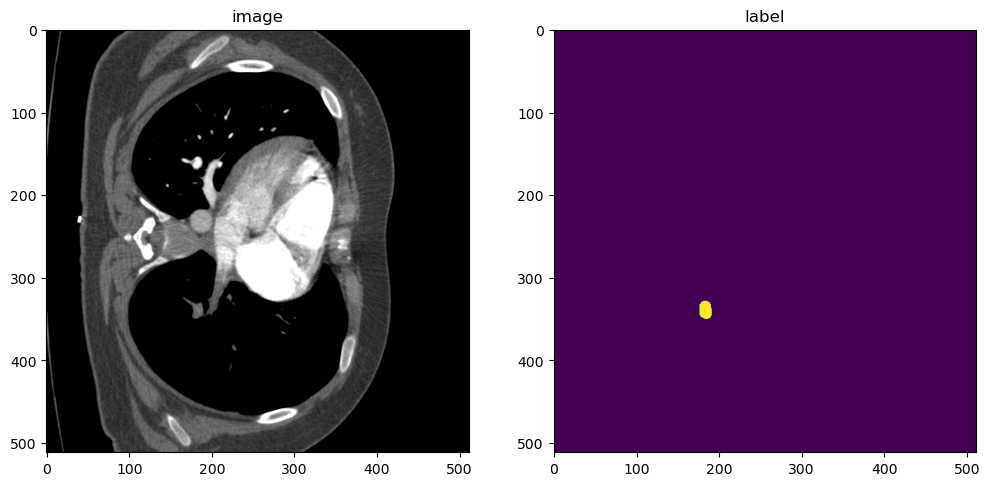

In [48]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 20]
idx = 100
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, idx])
plt.show()

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=cache_rate, num_workers=2)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset:  52%|█████▏    | 13/25 [01:03<00:52,  4.39s/it]

In [ ]:
from monai.utils import first
import numpy as np

sample = first(train_loader)

print("📦 Batch shape:", sample["image"].shape)  # (B, C, H, W, D)

for i in range(sample["label"].shape[0]):
    label_patch = sample["label"][i][0]  # [0] = squeeze channel
    pe_voxels = label_patch.sum().item()
    print(f"🧠 Patch {i}: PE voxels = {pe_voxels}")

In [ ]:
def save_checkpoint():
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "epoch": epoch,
        "offset": offset,
        "best_metric": best_metric,
        "best_metric_epoch": best_metric_epoch
    }, os.path.join(run_save_dir, "checkpoint.pth"))

In [ ]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 🔁 Switched loss to DiceFocalLoss
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",         # Since lower loss is better
    factor=0.9,         # Halve LR if no improvement
    patience=10,        # Wait 10 epochs
    verbose=True,
    min_lr=1e-5         # Don’t go below this
)

In [ ]:
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore", message=".*unable to generate class balanced samples.*")

In [ ]:
# Optional: Load checkpoint
resume = os.path.exists(os.path.join(run_save_dir, "checkpoint.pth"))
if resume:
    checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"]) 
    start_epoch = checkpoint["epoch"] + 1
    best_metric = checkpoint["best_metric"]
    best_metric_epoch = checkpoint["best_metric_epoch"]
    print(f"[🔄] Resuming from epoch {start_epoch}, best metric {best_metric:.4f}")
else:
    start_epoch = 0
    offset = 0
    best_metric = -1
    best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
epoch_range = trange(start_epoch, start_epoch + epochs, desc="Training Epochs")

# --- Training Loop ---
for epoch in epoch_range:
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss, "train/lr": optimizer.param_groups[0]["lr"]}, step=epoch)

    # --- Validation ---
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()
                val_steps += 1

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

        val_loss /= val_steps
        metric = dice_metric.aggregate().item()
        dice_metric.reset()

        metric_values.append(metric)
        wandb.log({"val/dice": metric, "val/loss": val_loss}, step=epoch)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            save_checkpoint()
            print("[💾] Saved new best metric model")

        if epoch % image_visual_epochs == 0:
            val_image = val_data["image"][0, 0].detach().cpu().numpy()
            val_label = val_data["label"][0, 0].detach().cpu().numpy()
            val_pred = torch.argmax(val_outputs[0], dim=0).detach().cpu().numpy()
            #mid_slice = val_image.shape[2] // 2
            mid_slice = 99
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            axs[0].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[0].set_title("Input")
            axs[1].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[1].imshow(val_pred[:, :, mid_slice], cmap="Reds", alpha=0.4)
            axs[1].set_title("Prediction on Input")
            axs[2].imshow(val_pred[:, :, mid_slice])
            axs[2].set_title("Prediction")
            axs[3].imshow(val_label[:, :, mid_slice])
            axs[3].set_title("Ground Truth")
            plt.tight_layout()
            wandb.log({"val/visual": wandb.Image(fig)}, step=epoch)
            plt.close(fig)
        scheduler.step(val_loss)


In [ ]:
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 150
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

## Generate Prediction Masks for Validation
Note we need to rotate 90 degress and flip along X axis

In [ ]:
import os
import torch
import nibabel as nib
import numpy as np
from monai.inferers import sliding_window_inference

# Load model
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

output_base_dir = os.path.join(run_save_dir, "predictions")
os.makedirs(output_base_dir, exist_ok=True)

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        image = batch["image"].to(device)  # (1, 1, H, W, D)
        image_path = val_loader.dataset.data[i]["image"]
        affine = nib.load(image_path).affine

        # Predict
        val_outputs = sliding_window_inference(image, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
        pred = torch.argmax(val_outputs, dim=1).cpu().numpy()[0]  # shape: (H, W, D)
        
        # ✅ Apply rotation and flip
        # pred = np.rot90(pred, k=1, axes=(0, 1))  # Rotate 90° counter-clockwise in XY
        pred = np.flip(pred, axis=0)             # Flip along X-axis
        pred = np.flip(pred, axis=1)             # Flip along X-axis

        print(f"[DEBUG] pred shape: {pred.shape}, unique values: {np.unique(pred)}")

        # Save directly without transformation
        patient_id = os.path.basename(os.path.dirname(image_path))
        os.makedirs(os.path.join(output_base_dir, patient_id), exist_ok=True)
        filename = os.path.basename(image_path).replace(".nii.gz", "_pred.nii.gz")
        save_path = os.path.join(output_base_dir, patient_id, filename)

        nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), save_path)
        print(f"✅ Saved: {save_path}")
